In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [11]:
# New timing data for multiple UE scenarios (seconds)
# Removed column: 'UEs register'
# Columns now: UEs, xApp Monitoring, Monitoring System, rApp Energy Optimization, Handover Process
import numpy as np

raw_data = [
    # UEs, xApp Monitoring, Monitoring System, rApp Energy Optimization, Handover Process
    (256,   0.254, 222.16, 1.501, 42),
    (512,   0.227, 449.87, 1.515, 132),
    (1024,  0.420, 912.66, 1.768, 279),
    (2048,  0.440,   0.00, 2.000, 1087),
    (4096,  0.805,   0.00, 2.950, 837),
    (8192,  1.920,   0.00, 5.793, 1004),
]

columns = ["UEs", "Prometheus", "Monitoring System", "rApp Energy Optimization", "Handover Process"]
df = pd.DataFrame(raw_data, columns=columns)

# Ensure numeric types
df[columns[1:]] = df[columns[1:]].apply(pd.to_numeric)

# Totals per UE scenario for percentage calculations
df['Total'] = df[columns[1:]].sum(axis=1)

processes = columns[1:]


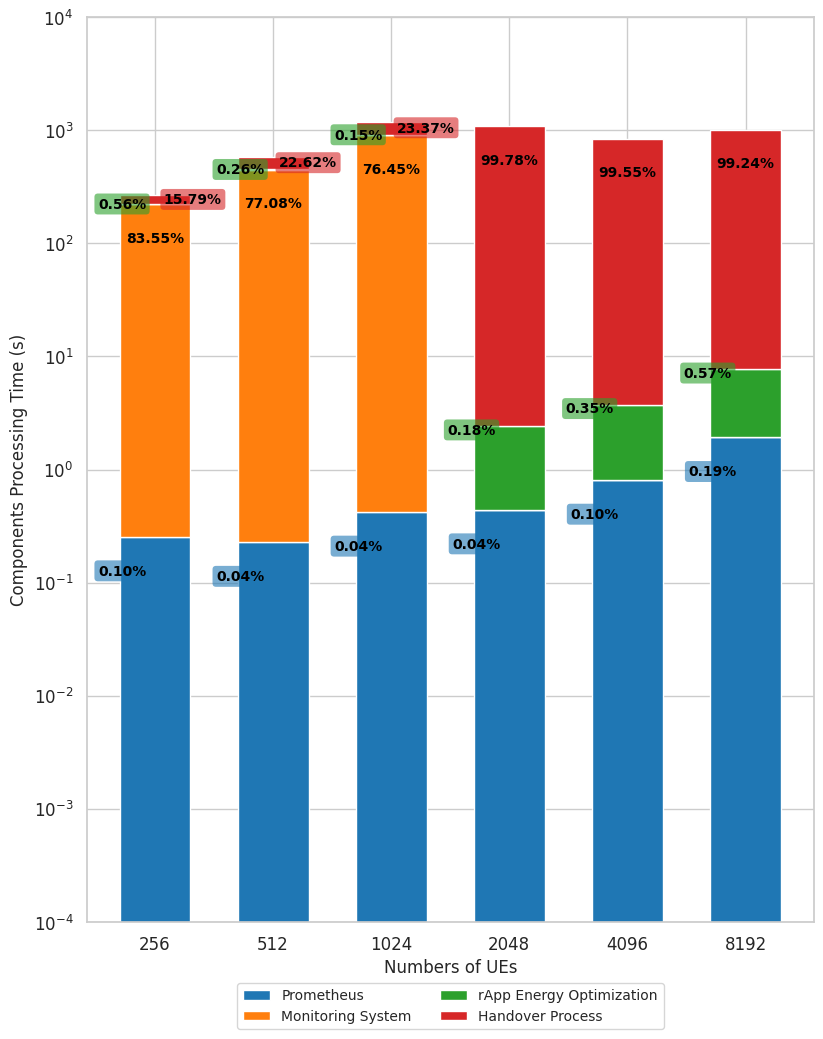

In [12]:
# Set seaborn style
sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(12*0.7, 15*0.7))

colors = sns.color_palette("tab10", len(processes))
bar_width = 0.6

# Build stacked bars
bottom = np.zeros(len(df))
for i, proc in enumerate(processes):
    values = df[proc].values
    ax.bar(df['UEs'].astype(str), values, bottom=bottom, color=colors[i], label=proc, width=bar_width)
    bottom += values

base_fontsize = 10
annotation_fontsize = 10  # uniform annotation font size (constant per user request)
# Removed path effects; using colored rounded bbox (matching bar) with semi-transparency

def fmt_pct(p):
    return f"{p:.2f}%"  # always two decimals

# Make sure canvas is drawn once so renderer exists for bbox calculations
fig.canvas.draw()
renderer = fig.canvas.get_renderer()
placed_bboxes = []

# Tuning parameters
min_vert_gap_factor = 0.015
base_offset = 0.05
extra_small_offset = 0.025
horiz_step = 0.04
max_horiz_push_attempts = 1
max_vertical_adjust_attempts = 15
small_pct_threshold = 0.2
center_pct_threshold = 0.5

for x_idx, ue in enumerate(df['UEs']):
    total = df.loc[df['UEs'] == ue, 'Total'].iloc[0]
    if total <= 0:
        continue
    cum = 0.0
    seg_index = 0
    placed_centers = []
    min_gap = total * min_vert_gap_factor
    for proc, color in zip(processes, colors):
        val = df.loc[df['UEs'] == ue, proc].iloc[0]
        if val <= 0:
            cum += val
            seg_index += 1
            continue
        start = cum
        end = cum + val
        pct = val / total * 100 if total > 0 else 0
        label = fmt_pct(pct)
        center = start + val/2
        for _ in range(max_vertical_adjust_attempts):
            if all(abs(center - c) >= min_gap for c in placed_centers):
                break
            center += min_gap
            if center > end - 0.1*val:
                center = end - 0.1*val
                break
        placed_centers.append(center)

        side = -1 if seg_index % 2 == 0 else 1
        use_center = (val / total) > center_pct_threshold
        tiny = (val / total) < small_pct_threshold

        if use_center:
            x_text = x_idx
            align = 'center'
        else:
            offset = base_offset + (extra_small_offset if tiny else 0)
            x_text = x_idx + offset * side
            align = 'right' if side < 0 else 'left'

        attempt = 0
        vert_micro_shift = 0.0
        text_obj = None
        while attempt <= max_horiz_push_attempts:
            if text_obj:
                text_obj.remove()
            text_obj = ax.text(
                x_text,
                center + vert_micro_shift,
                label,
                ha=align,
                va='center',
                fontsize=annotation_fontsize,
                fontweight='bold',
                color='black',
                bbox=dict(boxstyle='round,pad=0.25', facecolor=color, edgecolor='none', alpha=0.6)
            )
            fig.canvas.draw()
            bbox = text_obj.get_window_extent(renderer=renderer).expanded(1.05, 1.15)
            collision = any(bbox.overlaps(pb) for pb in placed_bboxes)
            if not collision:
                placed_bboxes.append(bbox)
                break
            if use_center:
                if attempt < max_vertical_adjust_attempts:
                    vert_micro_shift += (0.02 * val)
                else:
                    use_center = False
                    align = 'left'
                    side = 1
                    x_text = x_idx + base_offset + (extra_small_offset if tiny else 0)
                attempt += 1
            else:
                push_multiplier = 1 + attempt * 0.4
                x_text = x_idx + (base_offset + (extra_small_offset if tiny else 0) + push_multiplier * horiz_step) * side
                if attempt % 3 == 2:
                    vert_micro_shift += 0.015 * val
                attempt += 1
        seg_index += 1
        cum = end

ax.set_ylabel('Components Processing Time (s)', fontsize=base_fontsize+2)
ax.set_xlabel('Numbers of UEs', fontsize=base_fontsize+2)
ax.set_yscale('log')
log_ticks = [10**exp for exp in range(-4, 5)]
ax.set_yticks(log_ticks)
ax.tick_params(axis='both', which='major', labelsize=base_fontsize + 2)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.06), ncol=2, fontsize=base_fontsize)
plt.tight_layout()

import os
os.makedirs('out', exist_ok=True)
plt.savefig('out/detailed-times-stacked.pdf', bbox_inches='tight')
plt.savefig('out/detailed-times-stacked.png', dpi=300, bbox_inches='tight')
plt.show()